<a href="https://colab.research.google.com/github/danoff/lending-a-hand-in-bringing-ballcarriers-down/blob/main/Run_regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is for the regression testing and correlation for the **Lending a Hand in Bringing Ballcarriers Down** analysis.

This dataset has been whittled down with python (especially the mysql library) from the one [provided by the competition](https://www.kaggle.com/competitions/nfl-big-data-bowl-2024/data). The only offensive players are ballcarriers. Data is inclusive of multiple play types:

* Designed Rush (66%)
* Completions (30%)
* Scramble (3%)

Completions begin immediately after the receiver catches the ball.

Each row of the .

I used ChatGPT, Google Gemini, and other websites on the internet that I found via search engines to assemble this workbook.

# Results

Ballcarrier distance did not significantly correlate with defenders less than 1 yard away.

A Pearson correlation was conducted to examine the relationship between ballcarrier speed and defenders less than 1 yard away. There was a very weak positive correlation between them, *r*(283334)=.092,*p*<.001.

    Despite the very weak correlation (0.0918), the relationship between ballCarrierSpeed and toPlayerDistanceToBallCarrier is statistically significant due to the extremely low p-value (0.0). This means that even though the strength of the correlation is minimal, the result is statistically reliable.

Significance testing shows that the correlation is not zero, but the practical significance (strength) of this correlation is very low.

By using a regression model, 0.08% of the variance in ballcarrier speed can be explained by defenders less than 1 yard away.

In [1]:
# Check the versions of libraries

# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.compat import lzip
import statsmodels
import matplotlib.pyplot as plt



%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn import metrics

%matplotlib inline
import seaborn as sns

# Load libraries

from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
scipy: 1.13.1
numpy: 1.26.4
matplotlib: 3.7.1
pandas: 2.2.2
sklearn: 1.5.2


In [2]:
# read CSV of analytics staff data

data = pd.read_csv('speed_dist_data_20231228.csv', header=0)
data = data.dropna()

In [3]:
# Look at the variable names

variablenames = data.keys()
print (variablenames)

Index(['gameId', 'playId', 'frameId', 'playType', 'ballCarrierNflId',
       'ballCarrierDisplayName', 'ballCarrierJerseyNumber', 'ballCarrierSpeed',
       'toPlayerNflId', 'toPlayerDisplayName', 'toPlayerDistanceToBallCarrier',
       'toPlayerAction_tackle', 'toPlayerAction_assist',
       'toPlayerAction_forcedFumble', 'toPlayerAction_missedTackle'],
      dtype='object')


In [4]:
# show headers from csv of our derived NextGenStats data

data.head()

,gameId,playId,frameId,playType,ballCarrierNflId,ballCarrierDisplayName,ballCarrierJerseyNumber,ballCarrierSpeed,toPlayerNflId,toPlayerDisplayName,toPlayerDistanceToBallCarrier,toPlayerAction_tackle,toPlayerAction_assist,toPlayerAction_forcedFumble,toPlayerAction_missedTackle
1,2022090800,56,1,Completion,42489,Stefon Diggs,14,6.23,38577,Bobby Wagner,11.01360,0,0,0,0
2,2022090800,56,1,Completion,42489,Stefon Diggs,14,6.23,41239,Aaron Donald,12.42790,0,0,0,0
3,2022090800,56,1,Completion,42489,Stefon Diggs,14,6.23,42816,Troy Hill,31.57940,0,0,0,0
4,2022090800,56,1,Completion,42489,Stefon Diggs,14,6.23,43294,Jalen Ramsey,3.63629,1,0,0,0
5,2022090800,56,1,Completion,42489,Stefon Diggs,14,6.23,43298,Leonard Floyd,12.25040,0,0,0,0


In [5]:
# describe csv of our derived NextGenStats data

data.describe()

,gameId,playId,frameId,ballCarrierNflId,ballCarrierJerseyNumber,ballCarrierSpeed,toPlayerNflId,toPlayerDistanceToBallCarrier,toPlayerAction_tackle,toPlayerAction_assist,toPlayerAction_forcedFumble,toPlayerAction_missedTackle
count,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06,5.828669e+06
mean,2.022099e+09,1.981037e+03,2.551169e+01,4.821888e+04,2.658427e+01,3.722866e+00,4.745870e+04,1.136076e+01,7.001581e-02,4.777746e-02,5.973920e-04,2.093171e-02
std,5.933397e+03,1.170471e+03,1.765263e+01,4.592537e+03,2.131973e+01,2.537812e+00,4.997624e+03,8.707313e+00,2.551737e-01,2.132951e-01,2.443430e-02,1.431558e-01
min,2.022091e+09,5.400000e+01,1.000000e+00,2.551100e+04,1.000000e+00,0.000000e+00,3.313100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.022093e+09,9.490000e+02,1.100000e+01,4.487900e+04,1.200000e+01,1.530000e+00,4.345500e+04,4.774620e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.022101e+09,1.997000e+03,2.300000e+01,4.780700e+04,2.400000e+01,3.700000e+00,4.652100e+04,9.287310e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.022102e+09,2.979000e+03,3.700000e+01,5.294200e+04,3.100000e+01,5.640000e+00,5.254700e+04,1.633590e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.022111e+09,5.096000e+03,1.640000e+02,5.515800e+04,8.900000e+01,1.080000e+01,5.524100e+04,9.675010e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
# Get the number of rows
row_count = len(data)

print(f'The number of rows in the CSV file is: {row_count}')

The number of rows in the CSV file is: 5828669


In [7]:
# made a dataframe to do some maniupulation
df = data

In [8]:
# removed the football which has a PlayerNflId of zero
df = df[df['toPlayerNflId'] != 0]

In [9]:
#describe dataframe table

row_count2 = len(df)

print(f'The number of rows in the CSV file is: {row_count2}')

The number of rows in the CSV file is: 5828669


In [10]:
# only included players who were lss than one yard away from the ballcarrier

df = df[df['toPlayerDistanceToBallCarrier'] < 1]

In [11]:
# Regular regression to ballcarrier speed based on defender distance

model = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2409.
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:15   Log-Likelihood:            -5.7921e+05
No. Observations:              283336   AIC:                         1.158e+06
Df Residuals:                  283334   BIC:                         1.158e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.0978      0.010    206.056      0.000       2.078       2.118
toPlayerDistanceToBallCarrier     0.7537      0.015     49.084      0.000       0.724       0.784
==============================================================================
Omnibus:                    29450.509   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39463.075
Skew:                           0.896   Prob(JB):                         0.00
Kurtosis:                       3.360   Cond. No.                         6.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
corr_coefficient, p_value = pearsonr(df['ballCarrierSpeed'], df['toPlayerDistanceToBallCarrier'])

print(f'The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: {corr_coefficient}')
print(f'The p-value is: {p_value}')

The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: 0.09182238125616068
The p-value is: 0.0


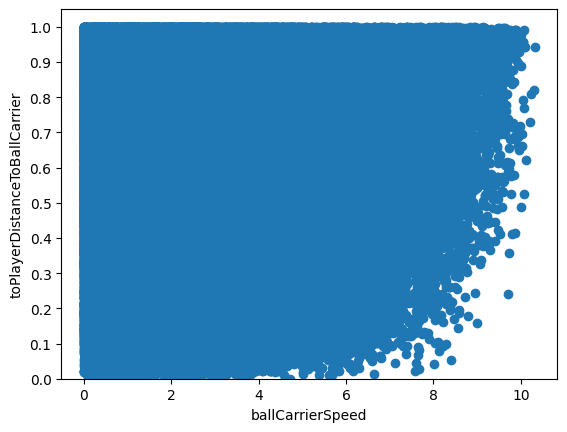

In [13]:
# Scatter Plot
# hat tip to https://www.statology.org/quadratic-regression-python/

plt.scatter(df['ballCarrierSpeed'], df['toPlayerDistanceToBallCarrier'])
plt.xlabel('ballCarrierSpeed')
plt.ylabel('toPlayerDistanceToBallCarrier')

# Adjust the y-axis range
plt.ylim(0, 1.05)

# Customize the y-axis ticks
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Rotate x-axis labels
plt.xticks(rotation=0)

plt.show()


In [14]:
# on second dataframe removed the football which has a PlayerNflId of zero
df2 = data
df2 = df2[df2['toPlayerNflId'] != 0]

In [15]:
# only included players who were less than two yards away from the ballcarrier

df2 = df2[df2['toPlayerDistanceToBallCarrier'] < 2]

In [16]:
# Get the number of rows
row_count = len(df2)

print(f'The number of rows in the CSV file is: {row_count}')

The number of rows in the CSV file is: 602516


In [17]:
# Regular regression to ballcarrier speed based on defender distance for those under 2 yards

model2 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                 1.818e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:17   Log-Likelihood:            -1.2905e+06
No. Observations:              602516   AIC:                         2.581e+06
Df Residuals:                  602514   BIC:                         2.581e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.1227      0.006    338.608      0.000       2.110       2.135
toPlayerDistanceToBallCarrier     0.7099      0.005    134.849      0.000       0.700       0.720
==============================================================================
Omnibus:                    41448.136   Durbin-Watson:                   0.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50625.301
Skew:                           0.709   Prob(JB):                         0.00
Kurtosis:                       2.913   Cond. No.                         4.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
corr_coefficient2, p_value = pearsonr(df2['ballCarrierSpeed'], df2['toPlayerDistanceToBallCarrier'])

print(f'The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: {corr_coefficient2}')
print(f'The p-value is: {p_value}')

The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: 0.17116189777538804
The p-value is: 0.0


In [19]:
# on third  dataframe removed the football which has a PlayerNflId of zero
df3 = data
df3 = df3[df3['toPlayerNflId'] != 0]

# only included players who were less than 3 yards away from the ballcarrier

df3 = df3[df3['toPlayerDistanceToBallCarrier'] < 3]

# Regular regression to ballcarrier speed based on defender distance for those under 3 yards

model3 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                 4.740e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:18   Log-Likelihood:            -1.9768e+06
No. Observations:              907680   AIC:                         3.954e+06
Df Residuals:                  907678   BIC:                         3.954e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2246      0.005    455.795      0.000       2.215       2.234
toPlayerDistanceToBallCarrier     0.6063      0.003    217.719      0.000       0.601       0.612
==============================================================================
Omnibus:                    44896.805   Durbin-Watson:                   0.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48061.378
Skew:                           0.538   Prob(JB):                         0.00
Kurtosis:                       2.662   Cond. No.                         4.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
corr_coefficient3, p_value = pearsonr(df3['ballCarrierSpeed'], df3['toPlayerDistanceToBallCarrier'])

print(f'The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: {corr_coefficient3}')
print(f'The p-value is: {p_value}')

The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: 0.22278044756735846
The p-value is: 0.0


In [21]:
# on fourth  dataframe removed the football which has a PlayerNflId of zero
df4 = data
df4 = df4[df4['toPlayerNflId'] != 0]

# only included players who were less than 3 yards away from the ballcarrier

df4 = df4[df4['toPlayerDistanceToBallCarrier'] < 4]

# Regular regression to ballcarrier speed based on defender distance for those under 2 yards

model4 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df4).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                 8.144e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:19   Log-Likelihood:            -2.6657e+06
No. Observations:             1217656   AIC:                         5.331e+06
Df Residuals:                 1217654   BIC:                         5.331e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.3507      0.004    569.377      0.000       2.343       2.359
toPlayerDistanceToBallCarrier     0.5056      0.002    285.382      0.000       0.502       0.509
==============================================================================
Omnibus:                    51070.686   Durbin-Watson:                   0.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47259.621
Skew:                           0.429   Prob(JB):                         0.00
Kurtosis:                       2.558   Cond. No.                         5.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:

# Compute the Pearson correlation coefficient and p-value
# thanks ChatGPT for the help


corr_coefficient4, p_value = pearsonr(df4['ballCarrierSpeed'], df4['toPlayerDistanceToBallCarrier'])

print(f'The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: {corr_coefficient4}')
print(f'The p-value is: {p_value}')

The correlation between ballCarrierSpeed and toPlayerDistanceToBallCarrier is: 0.25038375761242115
The p-value is: 0.0


In [23]:
# try running regression again with additional variables

# on fifth  dataframe removed the football which has a PlayerNflId of zero
df5 = data
df5 = df5[df5['toPlayerNflId'] != 0]

# only included players who were less than 3 yards away from the ballcarrier

df5 = df5[df5['toPlayerDistanceToBallCarrier'] < 4]

# Multiple regression to ballcarrier speed

model5 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier + toPlayerAction_forcedFumble + toPlayerAction_tackle + toPlayerAction_assist + toPlayerAction_missedTackle", data= df5).fit()

model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 3.022e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:20   Log-Likelihood:            -2.6339e+06
No. Observations:             1217656   AIC:                         5.268e+06
Df Residuals:                 1217650   BIC:                         5.268e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.7626      0.005    352.449      0.000       1.753       1.772
toPlayerDistanceToBallCarrier     0.6432      0.002    341.563      0.000       0.639       0.647
toPlayerAction_forcedFumble       0.4271      0.050      8.536      0.000       0.329       0.525
toPlayerAction_tackle             1.2454      0.005    230.982      0.000       1.235       1.256
toPlayerAction_assist             0.2804      0.006     44.481      0.000       0.268       0.293
toPlayerAction_missedTackle       1.2543      0.010    127.991      0.000       1.235       1.274
==============================================================================
Omnibus:                    41485.414   Durbin-Watson:                   0.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39596.022
Skew:                           0.398   Prob(JB):                         0.00
Kurtosis:                       2.617   Cond. No.                         65.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

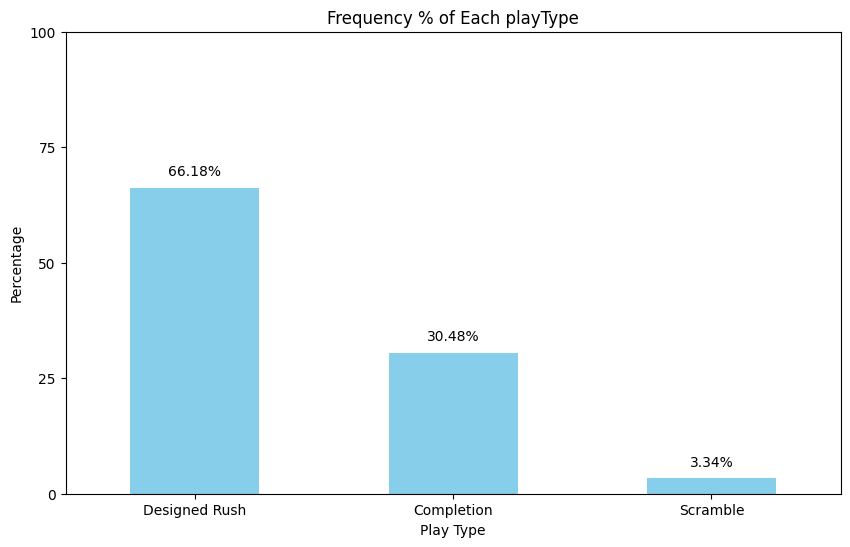

In [24]:
# make bar chart showing volume by play type
# code below is from chatGPT 40 and I modified it to fit this notebook


df6 = data
# make sixth dataframe for this chart
df6 = pd.DataFrame(data.playType)

# Count the frequency of each category
category_counts = df6['playType'].value_counts()

# Convert the counts to percentages
category_percentages = (category_counts / category_counts.sum()) * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
category_percentages.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Frequency % of Each playType')
plt.xlabel('Play Type')
plt.ylabel('Percentage')

# Adjust the y-axis range
plt.ylim(0, 100)

# Customize the y-axis ticks
plt.yticks([0, 25, 50, 75, 100])

# Rotate x-axis labels
plt.xticks(rotation=0)

# Add column data labels
for index, value in enumerate(category_percentages):
    plt.text(index, value + 2, f'{value:.2f}%', ha='center', va='bottom')

# Show the bar chart
plt.show()


In [25]:
# regression just for designed rushes

# on seventh  dataframe removed the football which has a PlayerNflId of zero and designed rushes
df7 = data
df7 = df7[(df7['toPlayerNflId'] != 0) & (df7['playType'] == 'Designed Rush')]

# only included players who were less than 3 yards away from the ballcarrier

df7 = df7[df7['toPlayerDistanceToBallCarrier'] < 2]

# Multiple regression to ballcarrier speed

model6 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df7).fit()

model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                 1.774e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:22   Log-Likelihood:            -9.1018e+05
No. Observations:              435276   AIC:                         1.820e+06
Df Residuals:                  435274   BIC:                         1.820e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.7846      0.007    249.848      0.000       1.771       1.799
toPlayerDistanceToBallCarrier     0.7859      0.006    133.190      0.000       0.774       0.798
==============================================================================
Omnibus:                    35939.556   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45538.034
Skew:                           0.785   Prob(JB):                         0.00
Kurtosis:                       3.210   Cond. No.                         4.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# regression just for completions

# on eigth dataframe removed the football which has a PlayerNflId of zero & just Completions & only included players who were less than 2 yards away from the ballcarrier

df8 = data
df8 = df8[(df8['toPlayerNflId'] != 0) & (df8['playType'] == 'Completion') & (df8['toPlayerDistanceToBallCarrier'] < 2)]

# Multiple regression to ballcarrier speed

model7 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df8).fit()

model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3600.
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:23   Log-Likelihood:            -3.4542e+05
No. Observations:              158404   AIC:                         6.909e+05
Df Residuals:                  158402   BIC:                         6.909e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.7825      0.012    229.917      0.000       2.759       2.806
toPlayerDistanceToBallCarrier     0.6448      0.011     60.000      0.000       0.624       0.666
==============================================================================
Omnibus:                    10207.235   Durbin-Watson:                   0.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8668.927
Skew:                           0.498   Prob(JB):                         0.00
Kurtosis:                       2.433   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# regression just for scrambles

# on ninth dataframe removed the football which has a PlayerNflId of zero & just scrambles & only included players who were less than 4 yards away from the ballcarrier

df9 = data
df9 = df9[(df9['toPlayerNflId'] != 0) & (df9['playType'] == 'Scramble') & (df9['toPlayerDistanceToBallCarrier'] < 2)]

# Multiple regression to ballcarrier speed

model8 = smf.ols("ballCarrierSpeed ~ toPlayerDistanceToBallCarrier", data= df9).fit()

model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     405.2
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           3.80e-88
Time:                        22:26:24   Log-Likelihood:                -19785.
No. Observations:                8836   AIC:                         3.957e+04
Df Residuals:                    8834   BIC:                         3.959e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.6457      0.066     55.132      0.000       3.516       3.775
toPlayerDistanceToBallCarrier     0.9997      0.050     20.129      0.000       0.902       1.097
==============================================================================
Omnibus:                      822.188   Durbin-Watson:                   0.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.977
Skew:                          -0.066   Prob(JB):                     1.17e-55
Kurtosis:                       2.182   Cond. No.                         5.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# Try quadratic regression with 10th dataframe

df10 = pd.DataFrame(data)
df10 = df10[(df10['toPlayerNflId'] != 0) & (df10['playType'] == 'Designed Rush') & (df10['toPlayerDistanceToBallCarrier'] < 4)]

# Add the squared term
df10['x_squared'] = df10['toPlayerDistanceToBallCarrier'] ** 2

# Define the predictors (including the constant term)
X = df10[['toPlayerDistanceToBallCarrier', 'x_squared']]
X = sm.add_constant(X)

# Adds the constant term to the model

# Define the response variable
y = df10['ballCarrierSpeed']

# Fit the model
model9 = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model9.summary())


<ipython-input-28-7296b2ea5c5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['x_squared'] = df10['toPlayerDistanceToBallCarrier'] ** 2


                            OLS Regression Results                            
Dep. Variable:       ballCarrierSpeed   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                 4.219e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:26:25   Log-Likelihood:            -1.9714e+06
No. Observations:              914228   AIC:                         3.943e+06
Df Residuals:                  914225   BIC:                         3.943e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         